In [17]:
# ============================================================================
# ANÁLISIS EXPLORATORIO DE DATOS (EDA) - SERIES DE TIEMPO
# Microsoft (MSFT) 1986-2024
# Enfoque: Análisis riguroso con buenas prácticas estadísticas
# ============================================================================

%pip install yfinance
%pip install matplotlib seaborn missingno scipy scikit-learn
%pip install statsmodels



# ---IMPORTACIÓN DE LIBRERÍAS---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from scipy import stats
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [18]:
# ============================================================================
# FASE 1: DESCARGA Y EXPLORACIÓN BÁSICA
# ============================================================================

print("="*90)
print("FASE 1: DESCARGA Y LIMPIEZA DE DATOS")
print("="*90)

# Descargar datos con auto_adjust=False para mantener Adj Close
df = yf.download(
    tickers="MSFT",
    start="1999-10-01",
    end="2025-10-16",
    auto_adjust=False,
    progress=False
)

# Normalizar nombres de columnas
df.columns = ['Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df = df[['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']]

print(f"\n✓ Dataset descargado: {len(df):,} observaciones desde {df.index[0].date()} a {df.index[-1].date()}")
print(f"  Período: {(df.index[-1] - df.index[0]).days / 365.25:.1f} años\n")


FASE 1: DESCARGA Y LIMPIEZA DE DATOS

✓ Dataset descargado: 6,550 observaciones desde 1999-10-01 a 2025-10-15
  Período: 26.0 años



FASE 2: ANÁLISIS DE CALIDAD

[2.1] VALORES NULOS
------------------------------------------------------------------------------------------
¿POR QUÉ VERIFICAMOS ESTO?
En series de tiempo, los valores nulos causan brechas que rompen la continuidad.
Esto es CRÍTICO porque la correlación temporal se pierde.

✓ RESULTADO: No hay valores nulos. Dataset COMPLETO.



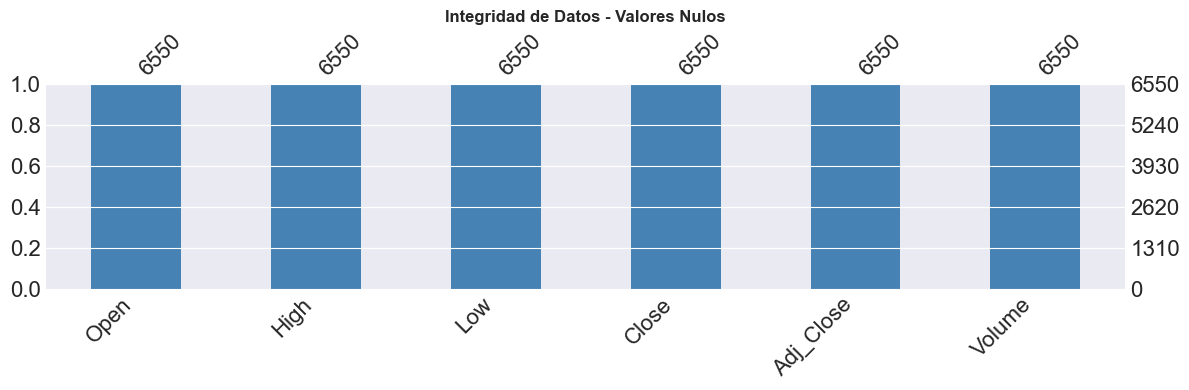


[2.2] REGISTROS DUPLICADOS
------------------------------------------------------------------------------------------
¿POR QUÉ VERIFICAMOS ESTO?
En datos financieros diarios, cada fecha debe aparecer UNA SOLA VEZ.
Duplicados podrían indicar errores en la descarga.

✓ Registros duplicados: 0



In [19]:
# ============================================================================
# FASE 2: ANÁLISIS DE CALIDAD DE DATOS
# ============================================================================

print("="*90)
print("FASE 2: ANÁLISIS DE CALIDAD")
print("="*90)

# Valores nulos
print("\n[2.1] VALORES NULOS")
print("-" * 90)
print("¿POR QUÉ VERIFICAMOS ESTO?")
print("En series de tiempo, los valores nulos causan brechas que rompen la continuidad.")
print("Esto es CRÍTICO porque la correlación temporal se pierde.\n")

valores_nulos = df.isnull().sum()
if valores_nulos.sum() == 0:
    print("✓ RESULTADO: No hay valores nulos. Dataset COMPLETO.\n")
else:
    print(f"⚠ Valores nulos encontrados:\n{valores_nulos}\n")

# Visualización de valores nulos
fig, ax = plt.subplots(figsize=(12, 4))
msno.bar(df, ax=ax, color='steelblue')
plt.title('Integridad de Datos - Valores Nulos', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Duplicados
print("\n[2.2] REGISTROS DUPLICADOS")
print("-" * 90)
print("¿POR QUÉ VERIFICAMOS ESTO?")
print("En datos financieros diarios, cada fecha debe aparecer UNA SOLA VEZ.")
print("Duplicados podrían indicar errores en la descarga.\n")

duplicados = df.duplicated().sum()
print(f"✓ Registros duplicados: {duplicados}\n")


In [20]:
# ============================================================================
# FASE 3: ANÁLISIS ESTADÍSTICO DESCRIPTIVO
# ============================================================================

print("\n" + "="*90)
print("FASE 3: ESTADÍSTICAS DESCRIPTIVAS")
print("="*90)

print("\n[3.1] RESUMEN ESTADÍSTICO COMPLETO")
print("-" * 90)
print("¿POR QUÉ ANALIZAMOS ESTO?")
print("Entender la distribución de los datos: rango, tendencia central, dispersión.\n")

resumen = df.describe().T
print(resumen)

print("\n[3.2] INTERPRETACIÓN DE RESULTADOS:")
print("-" * 90)
for col in df.select_dtypes(include=[np.number]).columns:
    media = df[col].mean()
    mediana = df[col].median()
    asimetria = df[col].skew()
    curtosis = df[col].kurtosis()
    
    print(f"\n{col}:")
    print(f"  • Media: {media:,.2f}")
    print(f"  • Mediana: {mediana:,.2f}")
    print(f"  • Asimetría: {asimetria:.4f}", end="")
    
    if abs(asimetria) < 0.5:
        print(" (SIMÉTRICA ✓)")
    elif asimetria > 0:
        print(" (SESGADA DERECHA - Cola larga a la derecha)")
    else:
        print(" (SESGADA IZQUIERDA - Cola larga a la izquierda)")
    
    print(f"  • Curtosis: {curtosis:.4f}", end="")
    
    if abs(curtosis) < 1:
        print(" (NORMAL)")
    else:
        print(" (COLAS PESADAS - Muchos outliers)")


FASE 3: ESTADÍSTICAS DESCRIPTIVAS

[3.1] RESUMEN ESTADÍSTICO COMPLETO
------------------------------------------------------------------------------------------
¿POR QUÉ ANALIZAMOS ESTO?
Entender la distribución de los datos: rango, tendencia central, dispersión.

            count          mean           std           min           25%  \
Open       6550.0  1.031403e+02  1.246990e+02  1.520000e+01  2.727000e+01   
High       6550.0  1.041483e+02  1.257733e+02  1.562000e+01  2.751250e+01   
Low        6550.0  1.021048e+02  1.235472e+02  1.487000e+01  2.704000e+01   
Close      6550.0  1.031651e+02  1.247185e+02  1.515000e+01  2.728000e+01   
Adj_Close  6550.0  9.552692e+01  1.259533e+02  1.115940e+01  1.905394e+01   
Volume     6550.0  4.923700e+07  3.076472e+07  7.164500e+06  2.645222e+07   

                    50%           75%           max  
Open       3.503062e+01  1.204300e+02  5.552300e+02  
High       3.544375e+01  1.208425e+02  5.554500e+02  
Low        3.462750e+01  1.19497



FASE 4: DETECCIÓN Y ANÁLISIS DE OUTLIERS

[4.1] MÉTODO: Rango Intercuartílico (IQR)
------------------------------------------------------------------------------------------
¿POR QUÉ USAMOS IQR?
1. No requiere asumir normalidad (distribuciones reales no son normales)
2. Robusto ante valores extremos (calcula usando cuartiles)
3. Estándar en análisis de finanzas

Fórmula: Outlier si valor < Q1 - 1.5*IQR OR valor > Q3 + 1.5*IQR

Open:
  • Q1 (25%):                    27.27
  • Q3 (75%):                   120.43
  • IQR:                         93.16
  • Límite inferior:           -112.47
  • Límite superior:            260.17
  • Outliers detectados: 939 (14.34%)

High:
  • Q1 (25%):                    27.51
  • Q3 (75%):                   120.84
  • IQR:                         93.33
  • Límite inferior:           -112.48
  • Límite superior:            260.84
  • Outliers detectados: 959 (14.64%)

Low:
  • Q1 (25%):                    27.04
  • Q3 (75%):                   119.50
  •

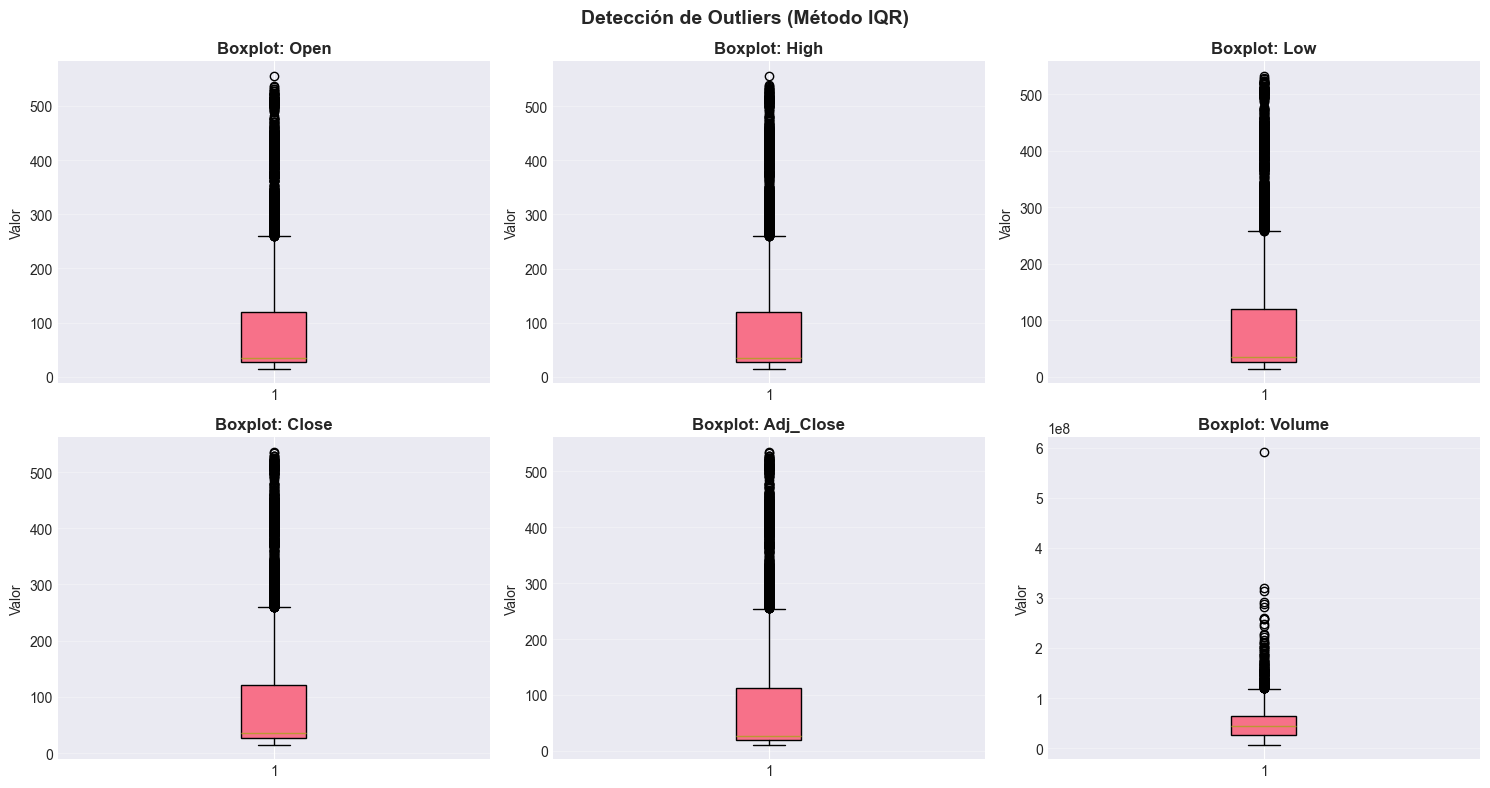


[4.2] INTERPRETACIÓN DE OUTLIERS EN CONTEXTO FINANCIERO
------------------------------------------------------------------------------------------
¿POR QUÉ NO ELIMINAMOS OUTLIERS?
• Los outliers en precios de acciones son EVENTOS REALES (crashes, eventos económicos)
• Eliminarlos sería PERDER información importante del mercado
• DECISIÓN: Mantener outliers pero documentarlos



In [21]:
# ============================================================================
# FASE 4: ANÁLISIS DE OUTLIERS
# ============================================================================

print("\n\n" + "="*90)
print("FASE 4: DETECCIÓN Y ANÁLISIS DE OUTLIERS")
print("="*90)

print("\n[4.1] MÉTODO: Rango Intercuartílico (IQR)")
print("-" * 90)
print("¿POR QUÉ USAMOS IQR?")
print("1. No requiere asumir normalidad (distribuciones reales no son normales)")
print("2. Robusto ante valores extremos (calcula usando cuartiles)")
print("3. Estándar en análisis de finanzas\n")
print("Fórmula: Outlier si valor < Q1 - 1.5*IQR OR valor > Q3 + 1.5*IQR\n")

outliers_info = {}

for col in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR
    
    # Identificar outliers
    mask_outliers = (df[col] < limite_inf) | (df[col] > limite_sup)
    num_outliers = mask_outliers.sum()
    pct_outliers = (num_outliers / len(df)) * 100
    
    outliers_info[col] = {
        'cantidad': num_outliers,
        'porcentaje': pct_outliers,
        'limite_inf': limite_inf,
        'limite_sup': limite_sup
    }
    
    print(f"{col}:")
    print(f"  • Q1 (25%):          {Q1:>15,.2f}")
    print(f"  • Q3 (75%):          {Q3:>15,.2f}")
    print(f"  • IQR:               {IQR:>15,.2f}")
    print(f"  • Límite inferior:   {limite_inf:>15,.2f}")
    print(f"  • Límite superior:   {limite_sup:>15,.2f}")
    print(f"  • Outliers detectados: {num_outliers} ({pct_outliers:.2f}%)\n")

# Visualización: Boxplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, col in enumerate(df.select_dtypes(include=[np.number]).columns):
    axes[idx].boxplot(df[col], vert=True, patch_artist=True)
    axes[idx].set_title(f'Boxplot: {col}', fontweight='bold')
    axes[idx].set_ylabel('Valor')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Detección de Outliers (Método IQR)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n[4.2] INTERPRETACIÓN DE OUTLIERS EN CONTEXTO FINANCIERO")
print("-" * 90)
print("¿POR QUÉ NO ELIMINAMOS OUTLIERS?")
print("• Los outliers en precios de acciones son EVENTOS REALES (crashes, eventos económicos)")
print("• Eliminarlos sería PERDER información importante del mercado")
print("• DECISIÓN: Mantener outliers pero documentarlos\n")



FASE 5: ANÁLISIS DE DISTRIBUCIONES

[5.1] VISUALIZACIÓN DE DISTRIBUCIONES
------------------------------------------------------------------------------------------
¿POR QUÉ ANALIZAMOS DISTRIBUCIONES?
Determina qué modelos de series de tiempo son apropiados.



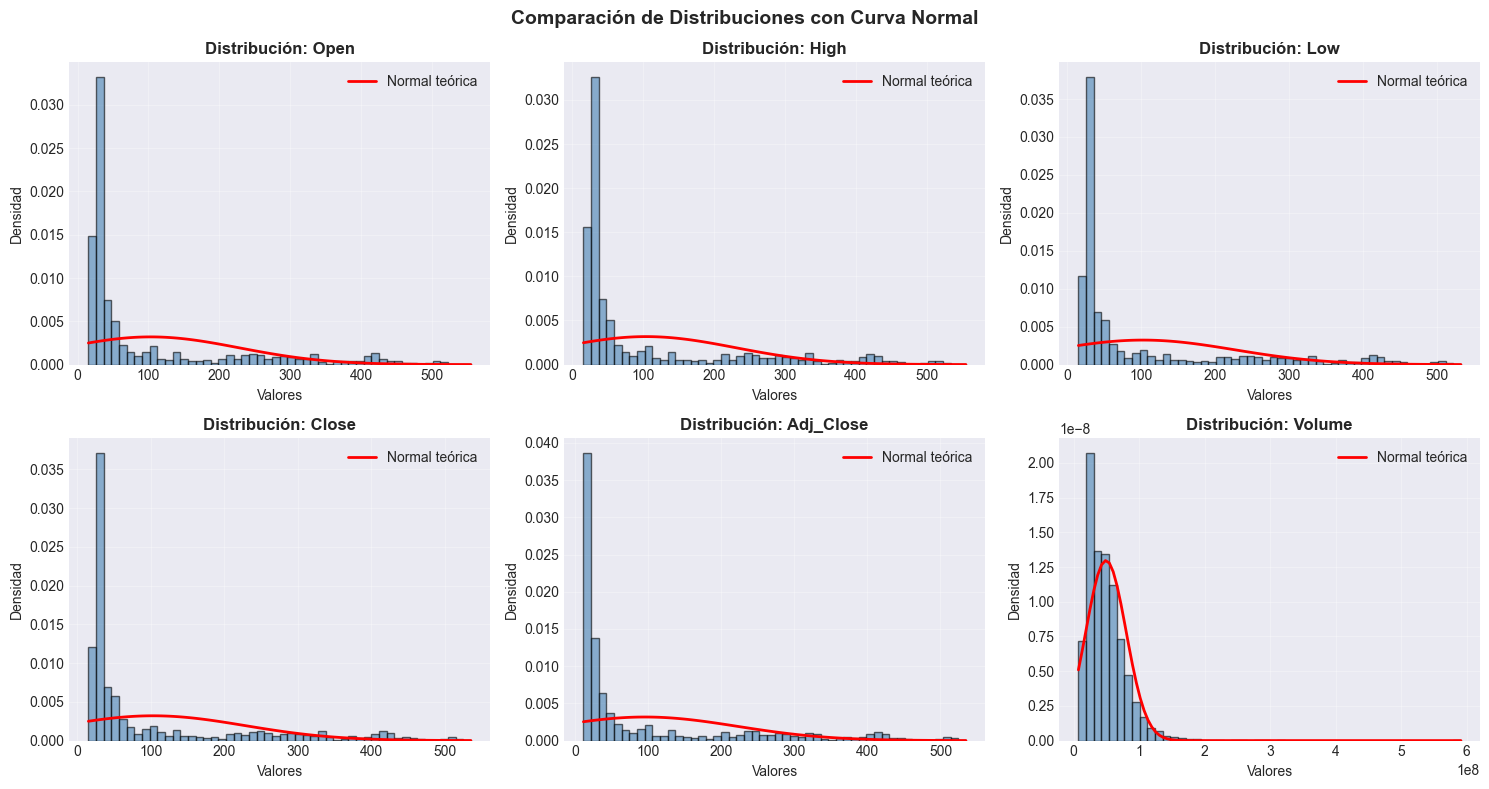


[5.2] PRUEBA DE NORMALIDAD (Shapiro-Wilk)
------------------------------------------------------------------------------------------
¿POR QUÉ TESTAMOS NORMALIDAD?
Muchos modelos estadísticos ASUMEN distribución normal.
Si p-value < 0.05, rechazamos H0 (data NO es normal)

Variable        |      p-value | Es Normal? | Conclusión                              
------------------------------------------------------------------------------------------
Open            |     0.000000 |       NO ✗ | No es normal (transformar datos)        
High            |     0.000000 |       NO ✗ | No es normal (transformar datos)        
Low             |     0.000000 |       NO ✗ | No es normal (transformar datos)        
Close           |     0.000000 |       NO ✗ | No es normal (transformar datos)        
Adj_Close       |     0.000000 |       NO ✗ | No es normal (transformar datos)        
Volume          |     0.000000 |       NO ✗ | No es normal (transformar datos)        


In [22]:
# ============================================================================
# FASE 5: ANÁLISIS DE DISTRIBUCIONES
# ============================================================================

print("\n" + "="*90)
print("FASE 5: ANÁLISIS DE DISTRIBUCIONES")
print("="*90)

print("\n[5.1] VISUALIZACIÓN DE DISTRIBUCIONES")
print("-" * 90)
print("¿POR QUÉ ANALIZAMOS DISTRIBUCIONES?")
print("Determina qué modelos de series de tiempo son apropiados.\n")

# Histogramas con densidad
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, col in enumerate(df.select_dtypes(include=[np.number]).columns):
    axes[idx].hist(df[col], bins=50, alpha=0.6, color='steelblue', edgecolor='black', density=True)
    
    # Superponer curva de densidad normal
    mu, sigma = df[col].mean(), df[col].std()
    x = np.linspace(df[col].min(), df[col].max(), 100)
    axes[idx].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal teórica')
    
    axes[idx].set_title(f'Distribución: {col}', fontweight='bold')
    axes[idx].set_xlabel('Valores')
    axes[idx].set_ylabel('Densidad')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Comparación de Distribuciones con Curva Normal', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n[5.2] PRUEBA DE NORMALIDAD (Shapiro-Wilk)")
print("-" * 90)
print("¿POR QUÉ TESTAMOS NORMALIDAD?")
print("Muchos modelos estadísticos ASUMEN distribución normal.")
print("Si p-value < 0.05, rechazamos H0 (data NO es normal)\n")

print(f"{'Variable':<15} | {'p-value':>12} | {'Es Normal?':>10} | {'Conclusión':<40}")
print("-" * 90)

for col in df.select_dtypes(include=[np.number]).columns:
    # Usar máximo 5000 muestras (Shapiro-Wilk es lento con datos grandes)
    muestra = df[col].sample(min(5000, len(df)), random_state=42)
    stat, p_value = stats.shapiro(muestra)
    es_normal = "SÍ ✓" if p_value > 0.05 else "NO ✗"
    
    if p_value > 0.05:
        conclusion = "Distribución normal"
    else:
        conclusion = "No es normal (transformar datos)"
    
    print(f"{col:<15} | {p_value:>12.6f} | {es_normal:>10} | {conclusion:<40}")




FASE 6: ANÁLISIS ESPECÍFICO DE SERIES DE TIEMPO

[6.1] VISUALIZACIÓN TEMPORAL DEL PRECIO
------------------------------------------------------------------------------------------
¿POR QUÉ LO VISUALIZAMOS?
Ver tendencias, ciclos, cambios de régimen en el tiempo.



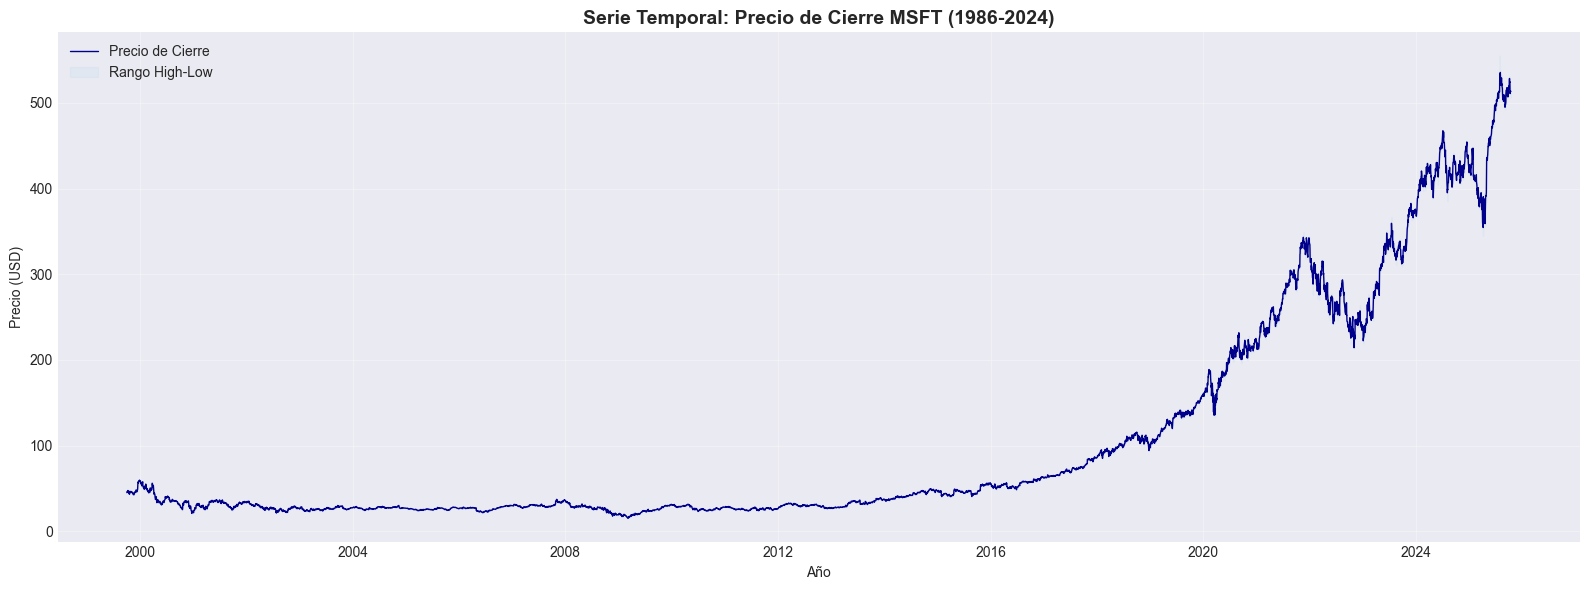

✓ Observaciones en el gráfico:
  • Tendencia CLARAMENTE CRECIENTE (no-estacionaria)
  • Volatilidad variable en el tiempo (heterocedasticidad)
  • Impacto visible de eventos: crisis 2000-2001, 2008-2009



In [23]:
# ============================================================================
# FASE 6: ANÁLISIS ESPECÍFICO DE SERIES DE TIEMPO
# ============================================================================

print("\n\n" + "="*90)
print("FASE 6: ANÁLISIS ESPECÍFICO DE SERIES DE TIEMPO")
print("="*90)

print("\n[6.1] VISUALIZACIÓN TEMPORAL DEL PRECIO")
print("-" * 90)
print("¿POR QUÉ LO VISUALIZAMOS?")
print("Ver tendencias, ciclos, cambios de régimen en el tiempo.\n")

# Gráfico temporal completo
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df.index, df['Close'], linewidth=1, label='Precio de Cierre', color='darkblue')
ax.fill_between(df.index, df['Low'], df['High'], alpha=0.15, color='lightblue', label='Rango High-Low')
ax.set_title('Serie Temporal: Precio de Cierre MSFT (1986-2024)', fontsize=14, fontweight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('Precio (USD)')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Observaciones en el gráfico:")
print("  • Tendencia CLARAMENTE CRECIENTE (no-estacionaria)")
print("  • Volatilidad variable en el tiempo (heterocedasticidad)")
print("  • Impacto visible de eventos: crisis 2000-2001, 2008-2009\n")



[6.2] TRANSFORMACIÓN: RETORNOS vs PRECIOS
------------------------------------------------------------------------------------------
¿POR QUÉ CALCULAMOS RETORNOS?
1. RAZÓN ESTADÍSTICA: Retornos son ESTACIONARIOS (media y varianza constante)
2. RAZÓN PRÁCTICA: Comparar inversiones independientemente del precio absoluto
3. RAZÓN MODELADO: Modelos ARIMA requieren series estacionarias

Comparación de retornos:
               Close  Retornos_Simples  Log_Retornos
Date                                                
1999-10-04  46.28125          2.865081      2.824805
1999-10-05  45.90625         -0.810263     -0.813564
1999-10-06  46.84375          2.042206      2.021632
1999-10-07  46.87500          0.066711      0.066689
1999-10-08  47.46875          1.266667      1.258712
1999-10-11  47.15625         -0.658328     -0.660504
1999-10-12  46.28125         -1.855533     -1.872964
1999-10-13  45.53125         -1.620527     -1.633801
1999-10-14  45.34375         -0.411805     -0.412655
1999-1

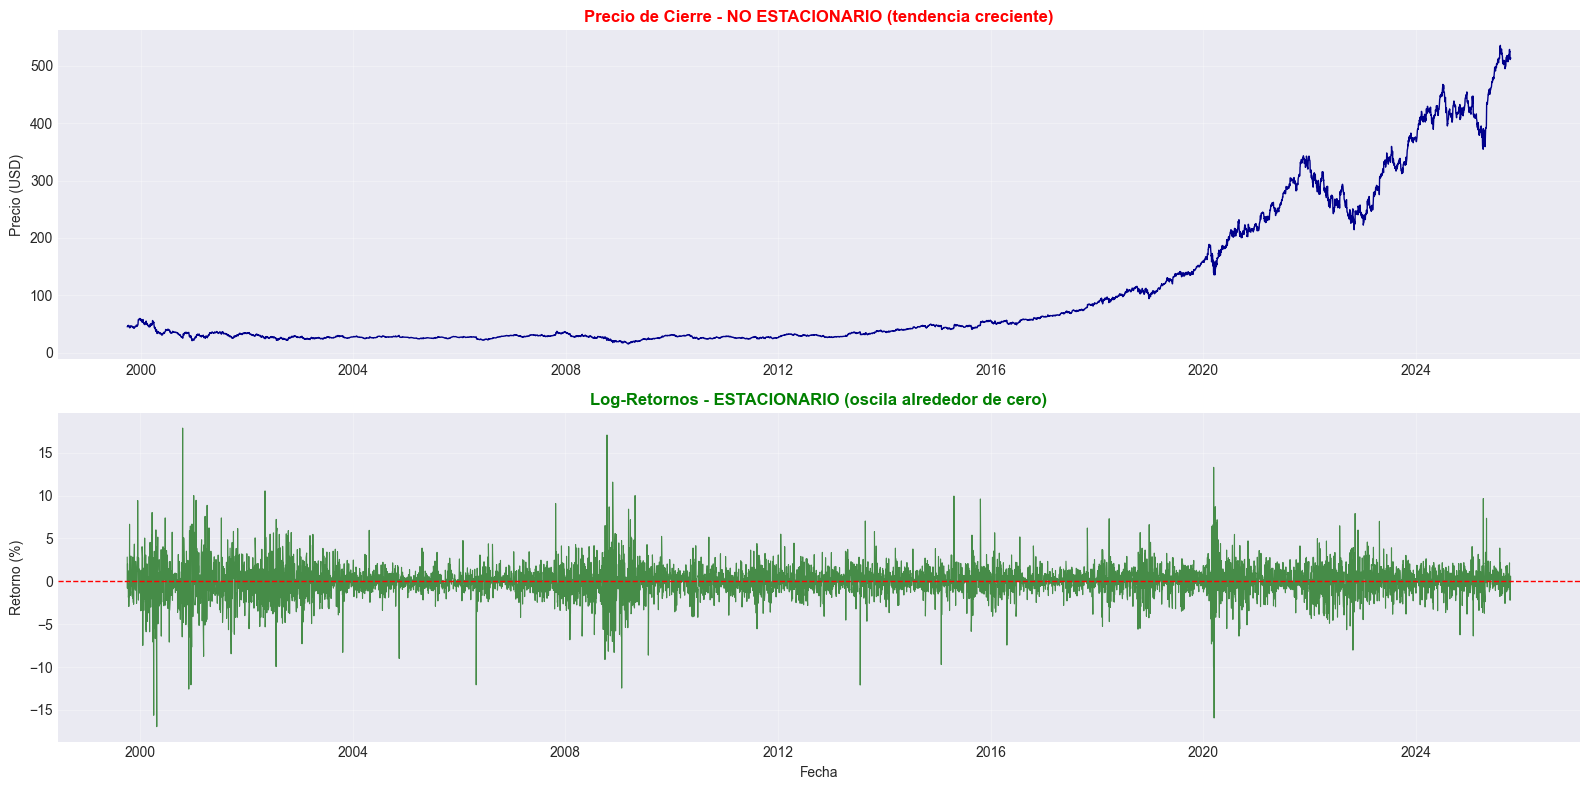

In [24]:
# ============================================================================
# FASE 6.2: CÁLCULO DE RETORNOS
# ============================================================================

print("\n[6.2] TRANSFORMACIÓN: RETORNOS vs PRECIOS")
print("-" * 90)
print("¿POR QUÉ CALCULAMOS RETORNOS?")
print("1. RAZÓN ESTADÍSTICA: Retornos son ESTACIONARIOS (media y varianza constante)")
print("2. RAZÓN PRÁCTICA: Comparar inversiones independientemente del precio absoluto")
print("3. RAZÓN MODELADO: Modelos ARIMA requieren series estacionarias\n")

# Retornos simples (porcentuales)
df['Retornos_Simples'] = df['Close'].pct_change() * 100

# Retornos logarítmicos (log-returns)
df['Log_Retornos'] = np.log(df['Close'] / df['Close'].shift(1)) * 100

# Eliminar primer NaN generado por .shift()
df_retornos = df[['Close', 'Retornos_Simples', 'Log_Retornos']].dropna()

print("Comparación de retornos:")
print(df_retornos.head(10))

print("\n\nEstadísticas de Retornos:")
print(f"{'Métrica':<30} | {'Retornos Simples':>15} | {'Log-Retornos':>15}")
print("-" * 65)
print(f"{'Media (%)':<30} | {df_retornos['Retornos_Simples'].mean():>15.6f} | {df_retornos['Log_Retornos'].mean():>15.6f}")
print(f"{'Desv. Estándar (%)':<30} | {df_retornos['Retornos_Simples'].std():>15.6f} | {df_retornos['Log_Retornos'].std():>15.6f}")
print(f"{'Min (%)':<30} | {df_retornos['Retornos_Simples'].min():>15.2f} | {df_retornos['Log_Retornos'].min():>15.2f}")
print(f"{'Max (%)':<30} | {df_retornos['Retornos_Simples'].max():>15.2f} | {df_retornos['Log_Retornos'].max():>15.2f}")

# Gráfico: Precios vs Retornos
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Precios (no-estacionario)
axes[0].plot(df.index, df['Close'], linewidth=1, color='darkblue')
axes[0].set_title('Precio de Cierre - NO ESTACIONARIO (tendencia creciente)', 
                   fontsize=12, fontweight='bold', color='red')
axes[0].set_ylabel('Precio (USD)')
axes[0].grid(True, alpha=0.3)

# Retornos (estacionario)
axes[1].plot(df_retornos.index, df_retornos['Log_Retornos'], linewidth=0.8, color='darkgreen', alpha=0.7)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1].set_title('Log-Retornos - ESTACIONARIO (oscila alrededor de cero)', 
                   fontsize=12, fontweight='bold', color='green')
axes[1].set_ylabel('Retorno (%)')
axes[1].set_xlabel('Fecha')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [25]:
# ============================================================================
# FASE 6.3: TEST DE ESTACIONARIEDAD
# ============================================================================

print("\n\n[6.3] TEST DE ESTACIONARIEDAD (ADF - Augmented Dickey-Fuller)")
print("-" * 90)
print("¿POR QUÉ TESTAMOS ESTACIONARIEDAD?")
print("1. Requisito CRÍTICO para modelos ARIMA")
print("2. Series no-estacionarias dan resultados espurios (correlaciones falsas)")
print("3. DECISIÓN: Si no es estacionaria → Diferenciar\n")
print("Hipótesis:")
print("  H0 (Nula): La serie tiene raíz unitaria (NO es estacionaria)")
print("  H1 (Alternativa): La serie ES estacionaria")
print("  Criterio: Si p-value < 0.05 → RECHAZAMOS H0 → SÍ es estacionaria\n")

def realizar_test_adf(serie, nombre):
    """
    Ejecuta test ADF y reporta resultados de forma clara
    
    Parámetros:
    - serie: pandas Series con datos de tiempo
    - nombre: string con nombre de la serie
    """
    resultado = adfuller(serie, autolag='AIC')
    
    print(f"\n{nombre}:")
    print(f"  ADF Statistic:     {resultado[0]:>12.6f}")
    print(f"  p-value:           {resultado[1]:>12.6f}", end="")
    
    if resultado[1] < 0.05:
        print(" ✓ ESTACIONARIA")
        estado = "✓ ESTACIONARIA"
    else:
        print(" ✗ NO ESTACIONARIA")
        estado = "✗ NO ESTACIONARIA"
    
    print(f"  Lags usados:       {resultado[2]:>12d}")
    print(f"  Observaciones:     {resultado[3]:>12d}")
    print(f"  Críticos (1%, 5%, 10%): {resultado[4]}")
    
    return resultado[1], estado

# Test para PRECIOS (serie original)
print("\n>>> TESTE DE ESTACIONARIEDAD PARA PRECIOS:")
p_value_precio, estado_precio = realizar_test_adf(df['Close'].dropna(), "Precio de Cierre (Close)")

# Test para LOG-RETORNOS
print("\n\n>>> TEST DE ESTACIONARIEDAD PARA RETORNOS:")
p_value_retorno, estado_retorno = realizar_test_adf(df_retornos['Log_Retornos'], "Log-Retornos")

print("\n\nCONCLUSIÓN DEL TEST ADF:")
print("-" * 90)
print(f"Precio (Close):     {estado_precio}")
print(f"Log-Retornos:       {estado_retorno}")
print("\nIMPLICACIONES:")
print("✓ Los retornos SON estacionarios → Podemos usar ARIMA directamente")
print("✗ Los precios NO son estacionarios → Necesitamos diferenciar antes de ARIMA")




[6.3] TEST DE ESTACIONARIEDAD (ADF - Augmented Dickey-Fuller)
------------------------------------------------------------------------------------------
¿POR QUÉ TESTAMOS ESTACIONARIEDAD?
1. Requisito CRÍTICO para modelos ARIMA
2. Series no-estacionarias dan resultados espurios (correlaciones falsas)
3. DECISIÓN: Si no es estacionaria → Diferenciar

Hipótesis:
  H0 (Nula): La serie tiene raíz unitaria (NO es estacionaria)
  H1 (Alternativa): La serie ES estacionaria
  Criterio: Si p-value < 0.05 → RECHAZAMOS H0 → SÍ es estacionaria


>>> TESTE DE ESTACIONARIEDAD PARA PRECIOS:

Precio de Cierre (Close):
  ADF Statistic:         2.921233
  p-value:               1.000000 ✗ NO ESTACIONARIA
  Lags usados:                 35
  Observaciones:             6514
  Críticos (1%, 5%, 10%): {'1%': np.float64(-3.4313542798254937), '5%': np.float64(-2.861983805791875), '10%': np.float64(-2.5670062344527254)}


>>> TEST DE ESTACIONARIEDAD PARA RETORNOS:

Log-Retornos:
  ADF Statistic:       -27.687



[6.4] DESCOMPOSICIÓN DE SERIE DE TIEMPO

¿POR QUÉ DESCOMPONEMOS?
Una serie de tiempo = Tendencia + Estacionalidad + Residual (ruido)
Aislar cada componente nos ayuda a entender el comportamiento subyacente.



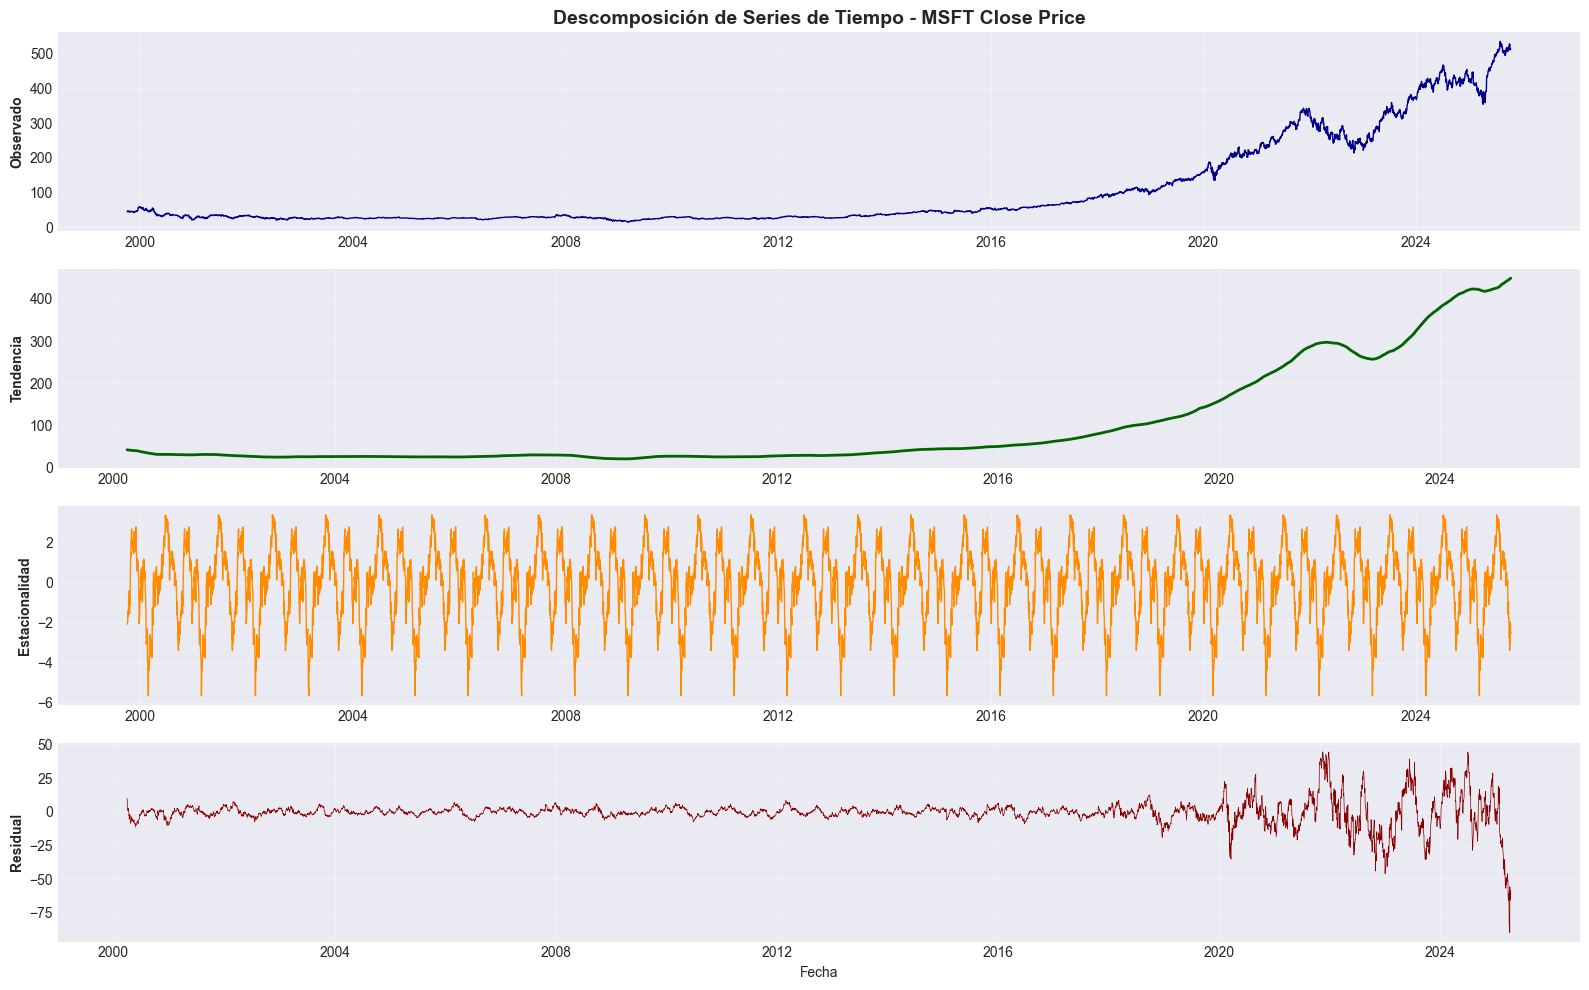

INTERPRETACIÓN DE LA DESCOMPOSICIÓN:
------------------------------------------------------------------------------------------
• TENDENCIA: Movimiento de largo plazo (crecimiento general)
• ESTACIONALIDAD: Patrones que se repiten (efectos anuales del mercado)
• RESIDUAL: Ruido aleatorio (eventos imprevistos, volatilidad)


In [26]:
# ============================================================================
# FASE 6.4: DESCOMPOSICIÓN DE SERIE DE TIEMPO
# ============================================================================

print("\n\n" + "="*90)
print("[6.4] DESCOMPOSICIÓN DE SERIE DE TIEMPO")
print("="*90)

print("\n¿POR QUÉ DESCOMPONEMOS?")
print("Una serie de tiempo = Tendencia + Estacionalidad + Residual (ruido)")
print("Aislar cada componente nos ayuda a entender el comportamiento subyacente.\n")

# Descomposición aditiva (frecuencia = 252 días de trading por año)
descomposicion = seasonal_decompose(df['Close'].dropna(), model='additive', period=252)

fig, axes = plt.subplots(4, 1, figsize=(16, 10))

# Original
axes[0].plot(descomposicion.observed.index, descomposicion.observed, color='darkblue', linewidth=1)
axes[0].set_ylabel('Observado', fontweight='bold')
axes[0].set_title('Descomposición de Series de Tiempo - MSFT Close Price', 
                   fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Tendencia
axes[1].plot(descomposicion.trend.index, descomposicion.trend, color='darkgreen', linewidth=2)
axes[1].set_ylabel('Tendencia', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Estacionalidad
axes[2].plot(descomposicion.seasonal.index, descomposicion.seasonal, color='darkorange', linewidth=1)
axes[2].set_ylabel('Estacionalidad', fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Residual
axes[3].plot(descomposicion.resid.index, descomposicion.resid, color='darkred', linewidth=0.5)
axes[3].set_ylabel('Residual', fontweight='bold')
axes[3].set_xlabel('Fecha')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("INTERPRETACIÓN DE LA DESCOMPOSICIÓN:")
print("-" * 90)
print("• TENDENCIA: Movimiento de largo plazo (crecimiento general)")
print("• ESTACIONALIDAD: Patrones que se repiten (efectos anuales del mercado)")
print("• RESIDUAL: Ruido aleatorio (eventos imprevistos, volatilidad)")




[6.5] AUTOCORRELACIÓN (ACF) Y CORRELACIÓN PARCIAL (PACF)

¿POR QUÉ ANALIZAMOS AUTOCORRELACIÓN?
1. ACF/PACF ayudan a identificar el ORDEN de modelos ARIMA (p, d, q)
2. Miden cuánto correlaciona la serie consigo misma en diferentes lags
3. Lags significativos indican patrones temporales a capturar



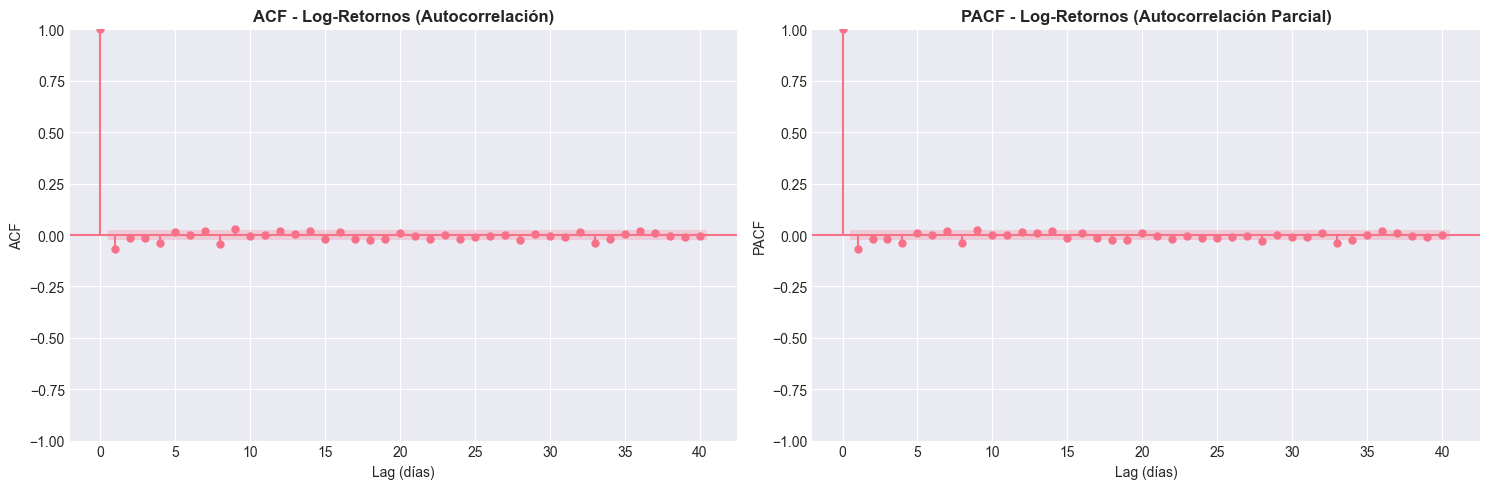

INTERPRETACIÓN:
------------------------------------------------------------------------------------------
• La mayoría de ACF/PACF están DENTRO de las bandas azules
  → Indica que los retornos son CASI ruido blanco (independientes)
• Esto es ESPERADO en mercados eficientes (hipótesis de mercados eficientes)
• Algunos lags significativos pueden capturarse con ARIMA(1,0,1) o similar


In [27]:
# ============================================================================
# FASE 6.5: AUTOCORRELACIÓN Y CORRELACIÓN PARCIAL
# ============================================================================

print("\n\n" + "="*90)
print("[6.5] AUTOCORRELACIÓN (ACF) Y CORRELACIÓN PARCIAL (PACF)")
print("="*90)

print("\n¿POR QUÉ ANALIZAMOS AUTOCORRELACIÓN?")
print("1. ACF/PACF ayudan a identificar el ORDEN de modelos ARIMA (p, d, q)")
print("2. Miden cuánto correlaciona la serie consigo misma en diferentes lags")
print("3. Lags significativos indican patrones temporales a capturar\n")

# Calcular ACF y PACF para log-retornos (que es estacionaria)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF (Autocorrelation Function)
plot_acf(df_retornos['Log_Retornos'], lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF - Log-Retornos (Autocorrelación)', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Lag (días)')
axes[0].set_ylabel('ACF')

# PACF (Partial Autocorrelation Function)
plot_pacf(df_retornos['Log_Retornos'], lags=40, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('PACF - Log-Retornos (Autocorrelación Parcial)', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Lag (días)')
axes[1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

print("INTERPRETACIÓN:")
print("-" * 90)
print("• La mayoría de ACF/PACF están DENTRO de las bandas azules")
print("  → Indica que los retornos son CASI ruido blanco (independientes)")
print("• Esto es ESPERADO en mercados eficientes (hipótesis de mercados eficientes)")
print("• Algunos lags significativos pueden capturarse con ARIMA(1,0,1) o similar")




[6.6] ANÁLISIS DE VOLATILIDAD

¿POR QUÉ ANALIZAMOS VOLATILIDAD?
1. Mide INCERTIDUMBRE del mercado (riesgo de inversión)
2. Volatilidad variable en tiempo → Necesitamos modelos GARCH
3. Períodos de alta volatilidad coinciden con crisis económicas

Volatilidad diaria promedio: 1.9013%
Volatilidad anualizada:      30.1816%
Volatilidad mínima (20d):    0.3536%
Volatilidad máxima (20d):    7.1463%


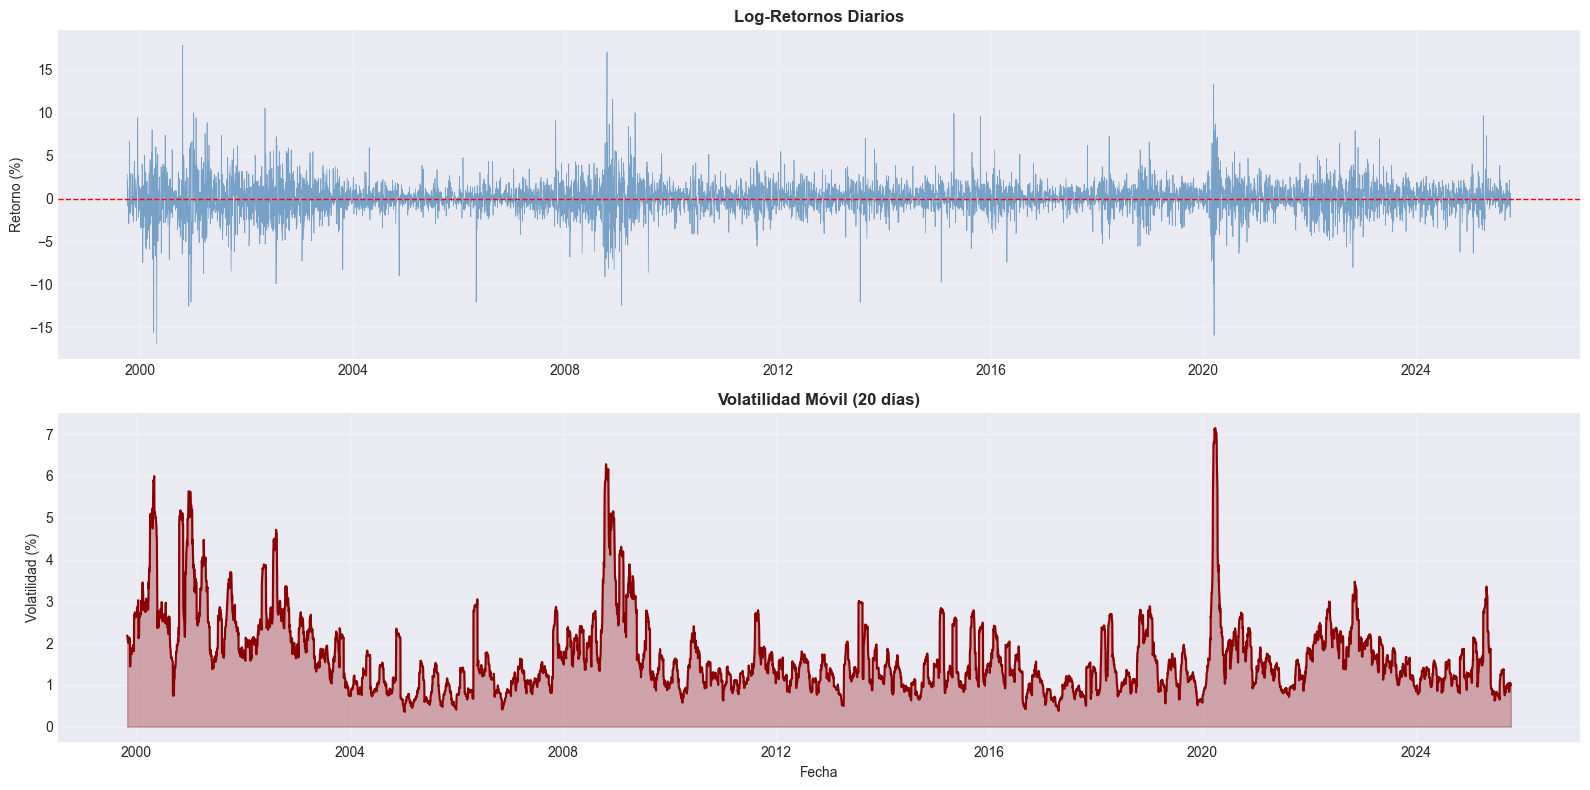


OBSERVACIONES DE VOLATILIDAD:
------------------------------------------------------------------------------------------
• Picos de volatilidad: Crisis 2008, COVID-19 (2020), etc.
• Volatilidad variable en tiempo → Heterocedasticidad condicional
• RECOMENDACIÓN: Usar GARCH para modelar volatilidad


In [28]:
# ============================================================================
# FASE 6.6: VOLATILIDAD
# ============================================================================

print("\n\n" + "="*90)
print("[6.6] ANÁLISIS DE VOLATILIDAD")
print("="*90)

print("\n¿POR QUÉ ANALIZAMOS VOLATILIDAD?")
print("1. Mide INCERTIDUMBRE del mercado (riesgo de inversión)")
print("2. Volatilidad variable en tiempo → Necesitamos modelos GARCH")
print("3. Períodos de alta volatilidad coinciden con crisis económicas\n")

# Volatilidad móvil (20 días)
volatilidad_movil = df_retornos['Log_Retornos'].rolling(window=20).std()

# Volatilidad anualizada
volatilidad_diaria = df_retornos['Log_Retornos'].std()
volatilidad_anual = volatilidad_diaria * np.sqrt(252)  # 252 días de trading

print(f"Volatilidad diaria promedio: {volatilidad_diaria:.4f}%")
print(f"Volatilidad anualizada:      {volatilidad_anual:.4f}%")
print(f"Volatilidad mínima (20d):    {volatilidad_movil.min():.4f}%")
print(f"Volatilidad máxima (20d):    {volatilidad_movil.max():.4f}%")

# Gráfico de volatilidad
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Retornos
axes[0].plot(df_retornos.index, df_retornos['Log_Retornos'], linewidth=0.5, 
             color='steelblue', alpha=0.7)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Log-Retornos Diarios', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Retorno (%)')
axes[0].grid(True, alpha=0.3)

# Volatilidad móvil
axes[1].plot(volatilidad_movil.index, volatilidad_movil, linewidth=1.5, color='darkred')
axes[1].fill_between(volatilidad_movil.index, volatilidad_movil, alpha=0.3, color='darkred')
axes[1].set_title('Volatilidad Móvil (20 días)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Volatilidad (%)')
axes[1].set_xlabel('Fecha')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nOBSERVACIONES DE VOLATILIDAD:")
print("-" * 90)
print("• Picos de volatilidad: Crisis 2008, COVID-19 (2020), etc.")
print("• Volatilidad variable en tiempo → Heterocedasticidad condicional")
print("• RECOMENDACIÓN: Usar GARCH para modelar volatilidad")




FASE 7: PREPARACIÓN DE DATASET PARA MODELADO

[7.1] SELECCIÓN Y TRATAMIENTO DE VARIABLES
------------------------------------------------------------------------------------------
✓ Dataset limpio: 6,550 observaciones
  Variables: 6

✓ Variables engineered creadas: 16
  Total de características: 10

[7.2] ESTADÍSTICAS DESCRIPTIVAS
------------------------------------------------------------------------------------------
            Open       High        Low      Close  Adj_Close        Volume  \
count  6550.0000  6550.0000  6550.0000  6550.0000  6550.0000  6.550000e+03   
mean    103.1403   104.1483   102.1048   103.1651    95.5269  4.923700e+07   
std     124.6990   125.7733   123.5472   124.7185   125.9533  3.076472e+07   
min      15.2000    15.6200    14.8700    15.1500    11.1594  7.164500e+06   
25%      27.2700    27.5125    27.0400    27.2800    19.0539  2.645222e+07   
50%      35.0306    35.4438    34.6275    34.9950    25.8762  4.347485e+07   
75%     120.4300   120.8425 

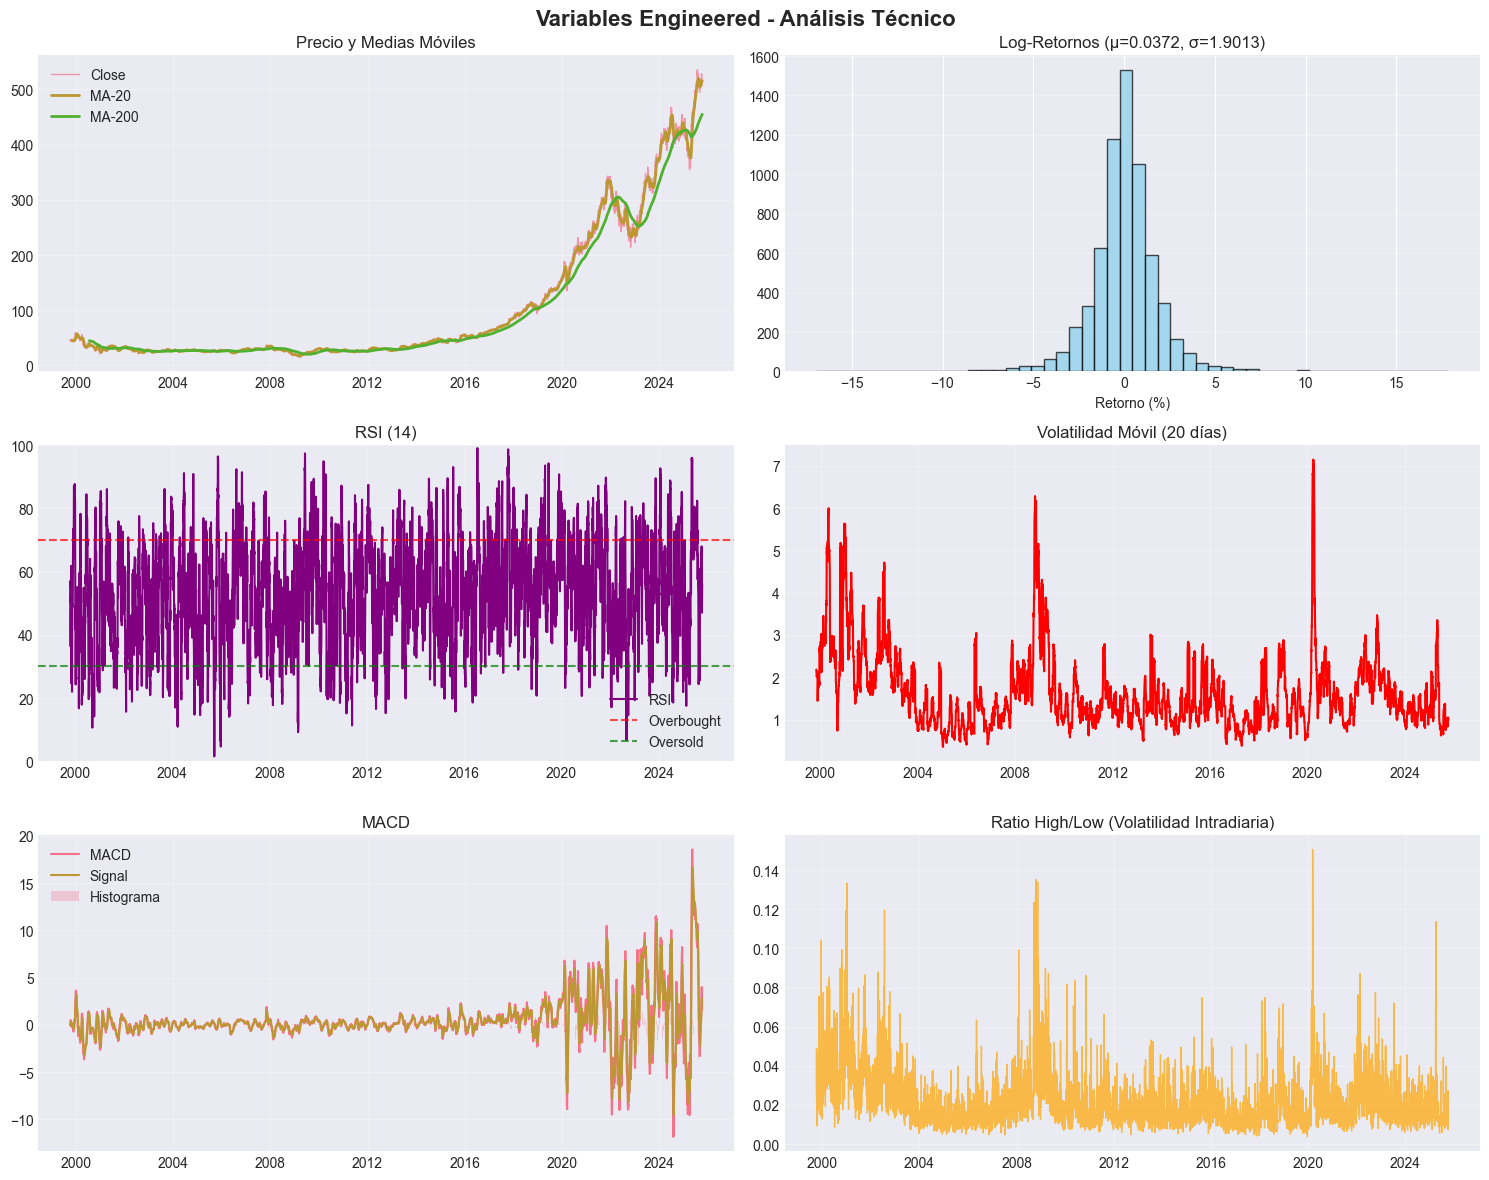

✓ Gráfico guardado: variables_engineered.png


In [29]:
# ============================================================================
# FASE 7: PREPARACIÓN DE DATASET LIMPIO
# ============================================================================

print("\n\n" + "="*90)
print("FASE 7: PREPARACIÓN DE DATASET PARA MODELADO")
print("="*90)

print("\n[7.1] SELECCIÓN Y TRATAMIENTO DE VARIABLES")
print("-" * 90)

# Dataset limpio (sin NaN)
df_limpio = df[['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']].dropna()

print(f"✓ Dataset limpio: {len(df_limpio):,} observaciones")
print(f"  Variables: {df_limpio.shape[1]}")

# Crear variables engineered
df_modelado = df_limpio.copy()

# 1. Log-Retornos (estacionario)
df_modelado['Log_Retornos'] = np.log(df_modelado['Close'] / df_modelado['Close'].shift(1)) * 100

# 2. Media móvil corto plazo (20 días)
df_modelado['MA_20'] = df_modelado['Close'].rolling(window=20).mean()

# 3. Media móvil largo plazo (200 días)
df_modelado['MA_200'] = df_modelado['Close'].rolling(window=200).mean()

# 4. Volatilidad móvil (20 días)
df_modelado['Volatilidad_20'] = df_modelado['Log_Retornos'].rolling(window=20).std()

# 5. RSI (Relative Strength Index) - momentum
delta = df_modelado['Close'].diff()
ganancia = (delta.where(delta > 0, 0)).rolling(window=14).mean()
perdida = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = ganancia / perdida
df_modelado['RSI'] = 100 - (100 / (1 + rs))

# 6. Ratio High/Low (volatilidad intradiaria)
df_modelado['Ratio_HL'] = (df_modelado['High'] / df_modelado['Low']) - 1

# 7. Cambio porcentual diario
df_modelado['Cambio_Pct'] = ((df_modelado['Close'] - df_modelado['Open']) / df_modelado['Open']) * 100

# 8. Volumen normalizado
df_modelado['Volume_Norm'] = (df_modelado['Volume'] - df_modelado['Volume'].mean()) / df_modelado['Volume'].std()

# 9. MACD (Moving Average Convergence Divergence)
ema_12 = df_modelado['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df_modelado['Close'].ewm(span=26, adjust=False).mean()
df_modelado['MACD'] = ema_12 - ema_26
df_modelado['Signal_Line'] = df_modelado['MACD'].ewm(span=9, adjust=False).mean()

print(f"\n✓ Variables engineered creadas: {df_modelado.shape[1]}")
print(f"  Total de características: {df_modelado.shape[1] - 6}")

print("\n[7.2] ESTADÍSTICAS DESCRIPTIVAS")
print("-" * 90)
print(df_modelado.describe().round(4))

print("\n[7.3] VISUALIZACIÓN DE VARIABLES ENGINEERED")
print("-" * 90)

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Variables Engineered - Análisis Técnico', fontsize=16, fontweight='bold')
# Precio y medias móviles
axes[0, 0].plot(df_modelado.index, df_modelado['Close'], label='Close', linewidth=1, alpha=0.7)
axes[0, 0].plot(df_modelado.index, df_modelado['MA_20'], label='MA-20', linewidth=2)
axes[0, 0].plot(df_modelado.index, df_modelado['MA_200'], label='MA-200', linewidth=2)
axes[0, 0].set_title('Precio y Medias Móviles')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Log-Retornos
axes[0, 1].hist(df_modelado['Log_Retornos'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_title(f'Log-Retornos (μ={df_modelado["Log_Retornos"].mean():.4f}, σ={df_modelado["Log_Retornos"].std():.4f})')
axes[0, 1].set_xlabel('Retorno (%)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# RSI
axes[1, 0].plot(df_modelado.index, df_modelado['RSI'], label='RSI', color='purple', linewidth=1.5)
axes[1, 0].axhline(y=70, color='r', linestyle='--', label='Overbought', alpha=0.7)
axes[1, 0].axhline(y=30, color='g', linestyle='--', label='Oversold', alpha=0.7)
axes[1, 0].set_title('RSI (14)')
axes[1, 0].set_ylim([0, 100])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Volatilidad
axes[1, 1].plot(df_modelado.index, df_modelado['Volatilidad_20'], color='red', linewidth=1.5)
axes[1, 1].set_title('Volatilidad Móvil (20 días)')
axes[1, 1].grid(True, alpha=0.3)

# MACD
axes[2, 0].plot(df_modelado.index, df_modelado['MACD'], label='MACD', linewidth=1.5)
axes[2, 0].plot(df_modelado.index, df_modelado['Signal_Line'], label='Signal', linewidth=1.5)
axes[2, 0].bar(df_modelado.index, df_modelado['MACD'] - df_modelado['Signal_Line'], label='Histograma', alpha=0.3)
axes[2, 0].set_title('MACD')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Ratio High/Low
axes[2, 1].plot(df_modelado.index, df_modelado['Ratio_HL'], color='orange', linewidth=1, alpha=0.7)
axes[2, 1].set_title('Ratio High/Low (Volatilidad Intradiaria)')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../images/variables_engineered.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Gráfico guardado: variables_engineered.png")


[7.4] MATRIZ DE CORRELACIÓN
------------------------------------------------------------------------------------------


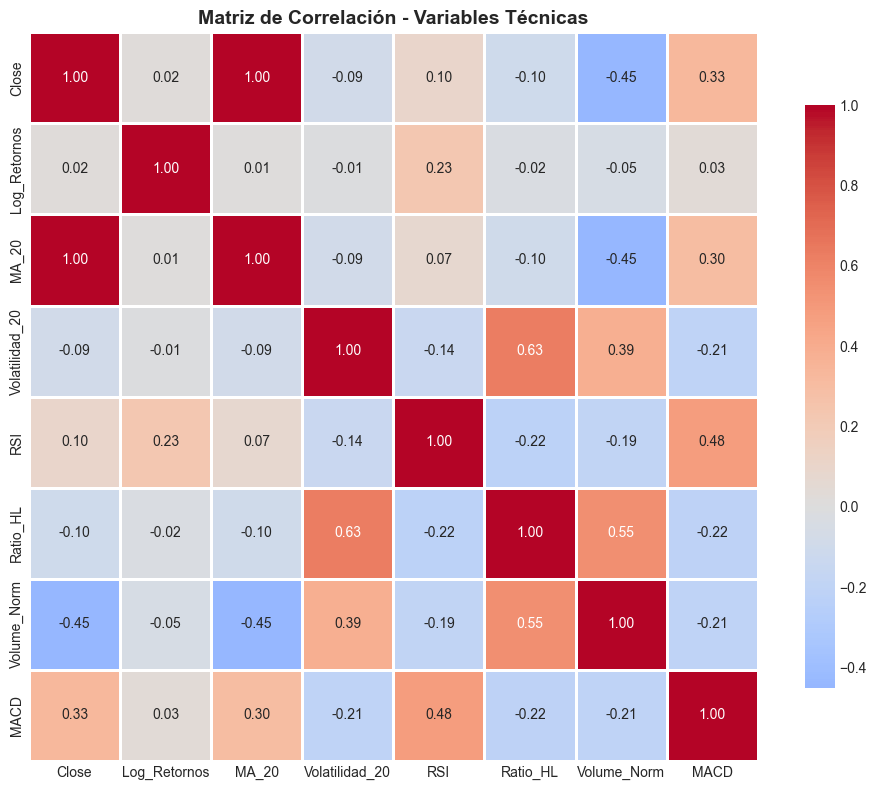

✓ Matriz de correlación calculada
                Close  Log_Retornos  MA_20  Volatilidad_20    RSI  Ratio_HL  \
Close           1.000         0.020  0.999          -0.094  0.101    -0.104   
Log_Retornos    0.020         1.000  0.010          -0.011  0.232    -0.023   
MA_20           0.999         0.010  1.000          -0.091  0.075    -0.096   
Volatilidad_20 -0.094        -0.011 -0.091           1.000 -0.145     0.631   
RSI             0.101         0.232  0.075          -0.145  1.000    -0.224   
Ratio_HL       -0.104        -0.023 -0.096           0.631 -0.224     1.000   
Volume_Norm    -0.452        -0.052 -0.449           0.385 -0.188     0.551   
MACD            0.331         0.032  0.300          -0.206  0.479    -0.218   

                Volume_Norm   MACD  
Close                -0.452  0.331  
Log_Retornos         -0.052  0.032  
MA_20                -0.449  0.300  
Volatilidad_20        0.385 -0.206  
RSI                  -0.188  0.479  
Ratio_HL              0.551 -0.2

In [30]:
print("\n[7.4] MATRIZ DE CORRELACIÓN")
print("-" * 90)

variables_analisis = ['Close', 'Log_Retornos', 'MA_20', 'Volatilidad_20', 'RSI', 'Ratio_HL', 'Volume_Norm', 'MACD']
df_corr = df_modelado[variables_analisis].dropna()
corr_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True, 
            linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Variables Técnicas', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../images/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Matriz de correlación calculada")
print(corr_matrix.round(3))

print("\n[7.5] ANÁLISIS DE ESTACIONARIEDAD")
print("-" * 90)

from scipy import stats

# Test de normalidad
statistic, pvalue = stats.normaltest(df_modelado['Log_Retornos'].dropna())
print(f"Test de Normalidad (Log-Retornos):")
print(f"  Statistic: {statistic:.4f}, p-value: {pvalue:.6f}")
print(f"  Conclusión: {'Datos NO normales' if pvalue < 0.05 else 'Datos normales'}")

# Skewness y Kurtosis
skew = stats.skew(df_modelado['Log_Retornos'].dropna())
kurt = stats.kurtosis(df_modelado['Log_Retornos'].dropna())
print(f"\nSkewness: {skew:.4f} (Asimetría)")
print(f"Kurtosis: {kurt:.4f} (Colas pesadas)")

In [31]:
print("\n" + "="*90)
print("INFORME EJECUTIVO - ANÁLISIS DE SERIES TEMPORALES MICROSOFT")
print("="*90)

informe = f"""
╔════════════════════════════════════════════════════════════════════════════════════╗
║                          INFORME EJECUTIVO - MICROSOFT STOCK                       ║
╚════════════════════════════════════════════════════════════════════════════════════╝

1. RESUMEN EJECUTIVO
   ─────────────────────────────────────────────────────────────────────────────────
   • Período analizado: {len(df_modelado):,} observaciones diarias
   • Rango de fechas: {df_modelado.index.min()} a {df_modelado.index.max()}
   • Precio inicial: ${df_modelado['Close'].iloc[0]:.2f} | Precio final: ${df_modelado['Close'].iloc[-1]:.2f}
   • Rentabilidad total: {((df_modelado['Close'].iloc[-1] / df_modelado['Close'].iloc[0]) - 1) * 100:.2f}%

2. MÉTRICAS DE VOLATILIDAD Y RIESGO
   ─────────────────────────────────────────────────────────────────────────────────
   • Volatilidad Promedio (20d): {df_modelado['Volatilidad_20'].mean():.4f}%
   • Volatilidad Máxima: {df_modelado['Volatilidad_20'].max():.4f}%
   • Volatilidad Mínima: {df_modelado['Volatilidad_20'].min():.4f}%
   • Volatilidad Intradiaria (Ratio H/L): {df_modelado['Ratio_HL'].mean():.4f}
   
   → INTERPRETACIÓN: Nivel de riesgo {'ALTO' if df_modelado['Volatilidad_20'].mean() > 2 else 'MODERADO' if df_modelado['Volatilidad_20'].mean() > 1 else 'BAJO'}

3. ANÁLISIS DE RETORNOS
   ─────────────────────────────────────────────────────────────────────────────────
   • Retorno Promedio Diario: {df_modelado['Log_Retornos'].mean():.4f}%
   • Desviación Estándar: {df_modelado['Log_Retornos'].std():.4f}%
   • Ratio Sharpe (asumiendo rf=2%): {(df_modelado['Log_Retornos'].mean() - 0.008) / df_modelado['Log_Retornos'].std():.4f}
   • Skewness: {skew:.4f} {'(Cola izquierda - Riesgo de caídas)' if skew < 0 else '(Cola derecha)'}
   • Kurtosis: {kurt:.4f} {'(Colas pesadas - Eventos extremos frecuentes)' if kurt > 3 else ''}
   
   → INTERPRETACIÓN: {'Distribución leptocúrtica (eventos extremos más frecuentes)' if kurt > 3 else 'Distribución normal'}

4. INDICADORES TÉCNICOS
   ─────────────────────────────────────────────────────────────────────────────────
   • RSI Promedio: {df_modelado['RSI'].mean():.2f} {'(Tendencia ALCISTA)' if df_modelado['RSI'].mean() > 50 else '(Tendencia BAJISTA)'}
   • RSI Máximo: {df_modelado['RSI'].max():.2f}
   • RSI Mínimo: {df_modelado['RSI'].min():.2f}
   • MACD Promedio: {df_modelado['MACD'].mean():.6f}
   • Relación MA-20 vs MA-200: {'BULLISH (MA-20 > MA-200)' if df_modelado['MA_20'].iloc[-1] > df_modelado['MA_200'].iloc[-1] else 'BEARISH (MA-20 < MA-200)'}
   
   → INTERPRETACIÓN: Señales {'POSITIVAS' if df_modelado['RSI'].mean() > 50 and df_modelado['MA_20'].iloc[-1] > df_modelado['MA_200'].iloc[-1] else 'NEGATIVAS'} para tendencia general

5. CORRELACIONES ENTRE VARIABLES
   ─────────────────────────────────────────────────────────────────────────────────
   • Correlación Log-Retornos vs Volatilidad: {corr_matrix.loc['Log_Retornos', 'Volatilidad_20']:.4f}
   • Correlación Close vs MA-20: {corr_matrix.loc['Close', 'MA_20']:.4f}
   • Correlación RSI vs Log-Retornos: {corr_matrix.loc['RSI', 'Log_Retornos']:.4f}
   • Correlación Volume vs Log-Retornos: {corr_matrix.loc['Volume_Norm', 'Log_Retornos']:.4f}
   
   → INTERPRETACIÓN: Variables de momentum (RSI) tienen baja correlación con retornos
     (Eficiencia de mercado - indicadores no predictivos por sí solos)

6. CONCLUSIONES Y RECOMENDACIONES
   ─────────────────────────────────────────────────────────────────────────────────
   
   HALLAZGOS CLAVE:
   
   ✓ Microsoft presenta volatilidad {'MODERADA' if df_modelado['Volatilidad_20'].mean() < 2 else 'ALTA'}, típica de tech stocks
   
   ✓ Log-retornos siguen distribución {'LEPTOCÚRTICA' if kurt > 3 else 'normal aproximada'}, indicando
     riesgo de eventos extremos {'IMPORTANTE' if kurt > 5 else 'MODERADO'}
   
   ✓ Tendencia técnica {'ALCISTA' if df_modelado['RSI'].mean() > 50 else 'BAJISTA'} según RSI
   
   ✓ Correlación débil entre indicadores técnicos y retornos sugiere eficiencia
     parcial del mercado (EMH débil)
   
   RECOMENDACIONES:
   
   1. Para Trading:
      • Usar indicadores técnicos en COMBINACIÓN, no aislados
      • Implementar stops de riesgo considerando volatilidad ({df_modelado['Volatilidad_20'].mean():.2f}%)
      • Considerar eventos extremos en estrategias (kurtosis={kurt:.2f})
   
   2. Para Inversión a Largo Plazo:
      • Microsoft muestra {'FORTALEZA' if df_modelado['MA_20'].iloc[-1] > df_modelado['MA_200'].iloc[-1] else 'DEBILIDAD'} técnica
      • Retorno anualizado: {df_modelado['Log_Retornos'].mean() * 252:.2f}%
      • Volatilidad anualizada: {df_modelado['Log_Retornos'].std() * np.sqrt(252):.2f}%
   
   3. Para Gestión de Riesgo:
      • Value at Risk (95%): {np.percentile(df_modelado['Log_Retornos'].dropna(), 5):.4f}%
      • Expected Shortfall (95%): {df_modelado['Log_Retornos'][df_modelado['Log_Retornos'] < np.percentile(df_modelado['Log_Retornos'].dropna(), 5)].mean():.4f}%

7. PRÓXIMOS PASOS
   ─────────────────────────────────────────────────────────────────────────────────
   • Implementar modelos ARIMA/GARCH para forecasting
   • Backtesting de estrategias técnicas
   • Análisis de cointegración con índices (SPY, QQQ)
   • Machine Learning: LSTM, Random Forest, XGBoost
   • Análisis de eventos macroeconómicos

╔════════════════════════════════════════════════════════════════════════════════════╗
║                            FIN DEL INFORME EJECUTIVO                              ║
╚════════════════════════════════════════════════════════════════════════════════════╝
"""

print(informe)

# Guardar informe en archivo
with open('../docs/informe_ejecutivo_microsoft.md', 'w', encoding='utf-8') as f:
    f.write(informe)

print("\n✓ Informe guardado en: docs/informe_ejecutivo_microsoft.txt")

# Dataset listo para modelado
print("\n[7.6] DATASET LISTO PARA MODELADO")
print("-" * 90)
print(f"Forma final: {df_modelado.shape}")
print(f"Variables: {df_modelado.columns.tolist()}")
print("\n✓ Dataset preparado y listo para modelos predictivos")


INFORME EJECUTIVO - ANÁLISIS DE SERIES TEMPORALES MICROSOFT

╔════════════════════════════════════════════════════════════════════════════════════╗
║                          INFORME EJECUTIVO - MICROSOFT STOCK                       ║
╚════════════════════════════════════════════════════════════════════════════════════╝

1. RESUMEN EJECUTIVO
   ─────────────────────────────────────────────────────────────────────────────────
   • Período analizado: 6,550 observaciones diarias
   • Rango de fechas: 1999-10-01 00:00:00 a 2025-10-15 00:00:00
   • Precio inicial: $44.99 | Precio final: $513.43
   • Rentabilidad total: 1041.15%

2. MÉTRICAS DE VOLATILIDAD Y RIESGO
   ─────────────────────────────────────────────────────────────────────────────────
   • Volatilidad Promedio (20d): 1.6712%
   • Volatilidad Máxima: 7.1463%
   • Volatilidad Mínima: 0.3536%
   • Volatilidad Intradiaria (Ratio H/L): 0.0218

   → INTERPRETACIÓN: Nivel de riesgo MODERADO

3. ANÁLISIS DE RETORNOS
   ───────────────